In [1]:
# install tensorboard???
!pip3 install tensorboard
#torchsummary useful for debugging network struct
!pip3 install torchsummary

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
import torchvision
import torchvision.datasets as datasets

batch_size_train = 64
batch_size_test = 64

#Load MNIST training/testing set into tensors
mnist_trainset = datasets.MNIST(root='./data_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

#Pass to dataloader
train_dl = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train)
test_dl = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size_test)

#Check shape of image
shape_ = mnist_trainset[0][0].shape
print(f'Shape of Image is {shape_}')

Shape of Image is torch.Size([1, 28, 28])


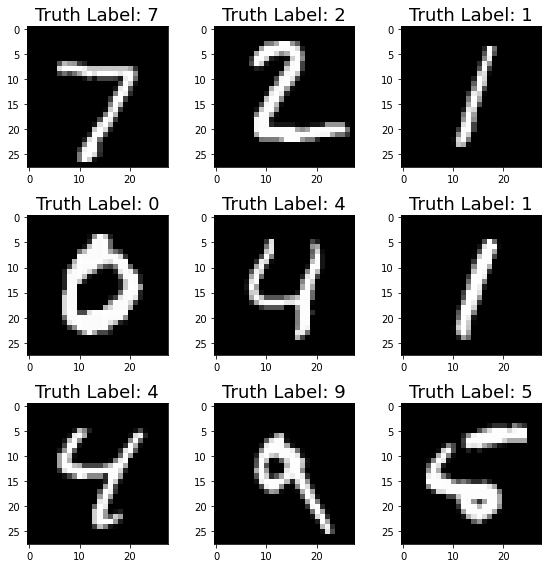

In [4]:
#Look at some examples of the testing set
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i, (example_data, example_targets) in enumerate(mnist_testset):
    if i >= 3*3: break
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data.permute(1, 2, 0), cmap='gray')
    plt.title("Truth Label: {}".format(example_targets), fontsize=18)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
from torchsummary import summary

#Check network struct
summary(Net(), (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [7]:
learning_rate = 0.01
momentum = 0.5

network = Net()
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     network = nn.DataParallel(network)
network.to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [8]:
from torch.utils.tensorboard import SummaryWriter

layout = {
    "MNIST": {
        "loss": ["Multiline", ["loss/train", "loss/test"]],
        "accuracy": ["Multiline", ["accuracy/train", "accuracy/test"]],
    },
}

log_interval = 10
writer = SummaryWriter()
writer.add_custom_scalars(layout)

In [9]:
def runTest(step):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dl:
            
            data, target = data.to(device), target.to(device)
            
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            
        test_loss /= len(test_dl.dataset)
        test_accuracy = correct / len(test_dl.dataset)
        writer.add_scalar('loss/test', test_loss, step)
        writer.add_scalar('accuracy/test', test_accuracy, step)
        
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dl.dataset),
        100. * test_accuracy))

In [10]:
def runTrain(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_dl):

        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
        
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        writer.add_scalar('loss/train', loss.item(), batch_idx+len(train_dl)*epoch)
        
        pred = output.data.max(1, keepdim=True)[1]
        
        correct = pred.eq(target.data.view_as(pred)).sum()
        train_accuracy = correct / len(data)
        writer.add_scalar('accuracy/train', train_accuracy, batch_idx+len(train_dl)*epoch)
        
        #runTest(batch_idx+len(train_dl)*epoch)
        
        if batch_idx % log_interval == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, batch_idx * len(data), len(train_dl.dataset),
            100. * batch_idx / len(train_dl), loss.item(), 
            correct, data.shape[0], 100. * train_accuracy))

In [11]:
%%time
n_epochs = 3
for epoch in range(1, n_epochs + 1):
    runTrain(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286826, Accuracy: 6/64 (9%)

Train Epoch: 1 [640/60000 (1%)]	Loss: 2.295846, Accuracy: 11/64 (17%)

Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.300465, Accuracy: 10/64 (16%)

Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.293709, Accuracy: 8/64 (12%)

Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.268546, Accuracy: 9/64 (14%)

Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.281609, Accuracy: 12/64 (19%)

Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.292991, Accuracy: 13/64 (20%)

Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.279999, Accuracy: 12/64 (19%)

Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.274850, Accuracy: 12/64 (19%)

Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.271307, Accuracy: 6/64 (9%)

Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.283533, Accuracy: 10/64 (16%)

Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.281842, Accuracy: 13/64 (20%)

Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.281439, Accuracy: 10/64 (16%)

Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.238944, Accuracy: 13/64 (20%

Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.920394, Accuracy: 50/64 (78%)

Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.820307, Accuracy: 47/64 (73%)

Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.508996, Accuracy: 53/64 (83%)

Train Epoch: 2 [13440/60000 (22%)]	Loss: 0.604871, Accuracy: 56/64 (88%)

Train Epoch: 2 [14080/60000 (23%)]	Loss: 0.821271, Accuracy: 49/64 (77%)

Train Epoch: 2 [14720/60000 (25%)]	Loss: 1.119491, Accuracy: 47/64 (73%)

Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.503687, Accuracy: 53/64 (83%)

Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.878196, Accuracy: 47/64 (73%)

Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.714255, Accuracy: 50/64 (78%)

Train Epoch: 2 [17280/60000 (29%)]	Loss: 0.348541, Accuracy: 58/64 (91%)

Train Epoch: 2 [17920/60000 (30%)]	Loss: 0.387768, Accuracy: 55/64 (86%)

Train Epoch: 2 [18560/60000 (31%)]	Loss: 0.406225, Accuracy: 57/64 (89%)

Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.623960, Accuracy: 55/64 (86%)

Train Epoch: 2 [19840/60000 (33%)]	Los

Train Epoch: 3 [24320/60000 (41%)]	Loss: 0.327168, Accuracy: 59/64 (92%)

Train Epoch: 3 [24960/60000 (42%)]	Loss: 0.436842, Accuracy: 52/64 (81%)

Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.390541, Accuracy: 55/64 (86%)

Train Epoch: 3 [26240/60000 (44%)]	Loss: 0.557372, Accuracy: 55/64 (86%)

Train Epoch: 3 [26880/60000 (45%)]	Loss: 0.507125, Accuracy: 57/64 (89%)

Train Epoch: 3 [27520/60000 (46%)]	Loss: 0.377811, Accuracy: 57/64 (89%)

Train Epoch: 3 [28160/60000 (47%)]	Loss: 0.469721, Accuracy: 56/64 (88%)

Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.477966, Accuracy: 57/64 (89%)

Train Epoch: 3 [29440/60000 (49%)]	Loss: 0.379311, Accuracy: 55/64 (86%)

Train Epoch: 3 [30080/60000 (50%)]	Loss: 0.543752, Accuracy: 53/64 (83%)

Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.330319, Accuracy: 59/64 (92%)

Train Epoch: 3 [31360/60000 (52%)]	Loss: 0.558606, Accuracy: 51/64 (80%)

Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.469128, Accuracy: 55/64 (86%)

Train Epoch: 3 [32640/60000 (54%)]	Los

In [12]:
#Check test samples accuracy
network = network.cpu()
all_mnist_testset = torch.unsqueeze(mnist_testset.data, 1).float()
mask = mnist_testset.targets != network(all_mnist_testset).data.max(1, keepdim=True)[1].flatten()
1-sum(mask).item()/len(mask)

0.8898

In [108]:
#torch.save(network.state_dict(), 'model_10epoch_Nov17.pt')
#network = torch.load('model_10epoch_Nov17.pt')

# network = Net()
# network.load_state_dict(torch.load('model_10epoch_Nov17.pt'))

RuntimeError: Error(s) in loading state_dict for Net:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "module.conv1.weight", "module.conv1.bias", "module.conv2.weight", "module.conv2.bias", "module.fc1.weight", "module.fc1.bias", "module.fc2.weight", "module.fc2.bias". 

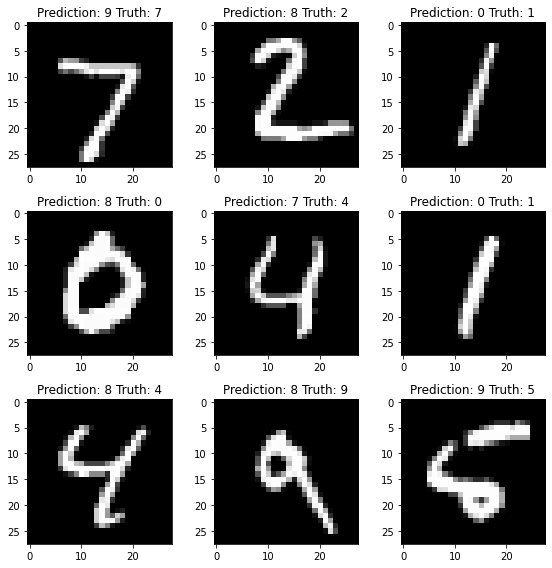

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
for i, (example_data, example_targets) in enumerate(mnist_testset):
        if i >= 3*3: break
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        plt.imshow(example_data.permute(1, 2, 0), cmap='gray')
        with torch.no_grad():
            prediction = network(example_data).data.max(1, keepdim=True)[1].item()
            plt.title("Prediction: {} Truth: {}".format(prediction, example_targets, fontsize=18))

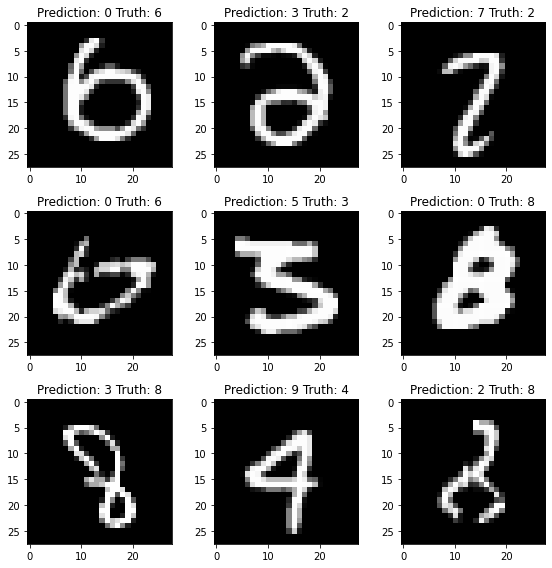

In [101]:
#Looking at some wrong examples
all_mnist_testset = torch.unsqueeze(mnist_testset.data, 1).float()
mask = mnist_testset.targets != network(all_mnist_testset).data.max(1, keepdim=True)[1].flatten().cpu()
fig = plt.figure(figsize=(8,8))
for i, (example_data, example_targets) in enumerate(zip(mnist_testset.data[mask], mnist_testset.targets[mask])):
        example_data = example_data.unsqueeze_(0).float()
        if i >= 3*3: break
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        plt.imshow(example_data.permute(1, 2, 0), cmap='gray')
        with torch.no_grad():
            prediction = network(example_data.to(device)).data.max(1, keepdim=True)[1].item()
            plt.title("Prediction: {} Truth: {}".format(prediction, example_targets, fontsize=18))